In [23]:
from pyspark.sql import  SQLContext 
from pyspark import SparkContext

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as f
from pyspark.sql import SQLContext, Row, SparkSession
import pandas as pd
from pyspark.sql.window import Window

from pyspark.sql.functions import when, udf, col, regexp_replace
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType, IntegerType, StringType
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
sc = SparkContext('local')
sqlctx = SQLContext(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/26 10:32:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/home/mobile/spark-3.3.1-bin-hadoop2/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
flight_df_2020_F = sqlctx.read.csv( './project/Feb_2020_ontime.csv', inferSchema=True, header = True)
flight_df_2019_F = sqlctx.read.csv( './project/Feb_2019_ontime.csv', inferSchema=True, header = True)
flight_df_2020_J = sqlctx.read.csv( './project/Jan_2020_ontime.csv', inferSchema=True, header = True)
flight_df_2019_J = sqlctx.read.csv( './project/Jan_2019_ontime.csv', inferSchema=True, header = True)

In [4]:
# 4개의 csv file union
flight_df = flight_df_2020_F.unionAll(flight_df_2019_F)
flight_df = flight_df.unionAll(flight_df_2020_J)
flight_df = flight_df.unionAll(flight_df_2019_J)

In [ ]:
print((flight_df.count(), len(flight_df.columns)))

In [5]:
#전체 컬럼 중 같은 데이터 및 null 컬럼 제거 
flight_df = flight_df.drop('OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','_c21', 'DEP_TIME', 'ARR_TIME')

In [6]:
#전체 컬럼 결측치 확인
flight_df.select([f.count(when(f.isnull(c), c)).alias(c) for c in flight_df.columns]).show()

+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_CARRIER|TAIL_NUM|OP_CARRIER_FL_NUM|ORIGIN_AIRPORT_SEQ_ID|ORIGIN|DEST_AIRPORT_SEQ_ID|DEST|DEP_DEL15|DEP_TIME_BLK|ARR_DEL15|CANCELLED|DIVERTED|DISTANCE|
+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+
|           0|          0|         0|    5067|                0|                    0|     0|                  0|   0|    42832|           0|    49153|        0|       0|       0|
+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+



In [7]:
flight_df = flight_df.fillna({'DEP_DEL15' : 0, 'ARR_DEL15' : 0})

In [8]:
#전체 컬럼 결측치 확인
flight_df.select([f.count(when(f.isnull(c), c)).alias(c) for c in flight_df.columns]).show()

+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_CARRIER|TAIL_NUM|OP_CARRIER_FL_NUM|ORIGIN_AIRPORT_SEQ_ID|ORIGIN|DEST_AIRPORT_SEQ_ID|DEST|DEP_DEL15|DEP_TIME_BLK|ARR_DEL15|CANCELLED|DIVERTED|DISTANCE|
+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+
|           0|          0|         0|    5067|                0|                    0|     0|                  0|   0|        0|           0|        0|        0|       0|       0|
+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+



In [9]:
# tail_num의 null값 제거
flight_df = flight_df.dropna(subset = ['TAIL_NUM'])

In [10]:
flight_df.select([f.count(when(f.isnull(c), c)).alias(c) for c in flight_df.columns]).show()

# 전체 컬럼의 null값 처리

+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_CARRIER|TAIL_NUM|OP_CARRIER_FL_NUM|ORIGIN_AIRPORT_SEQ_ID|ORIGIN|DEST_AIRPORT_SEQ_ID|DEST|DEP_DEL15|DEP_TIME_BLK|ARR_DEL15|CANCELLED|DIVERTED|DISTANCE|
+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+
|           0|          0|         0|       0|                0|                    0|     0|                  0|   0|        0|           0|        0|        0|       0|       0|
+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+



In [11]:
#항공사별 운행횟수
flight_df.groupby('ORIGIN').agg(f.count('ORIGIN').alias('cnt_ori')).orderBy(f.desc('cnt_ori')).show()

+------+-------+
|ORIGIN|cnt_ori|
+------+-------+
|   ATL| 121458|
|   ORD|  99615|
|   DFW|  91433|
|   CLT|  75292|
|   DEN|  75062|
|   LAX|  68691|
|   PHX|  58148|
|   IAH|  57023|
|   LGA|  53489|
|   SFO|  52492|
|   LAS|  52311|
|   DTW|  48957|
|   MCO|  48136|
|   MSP|  47100|
|   BOS|  45711|
|   DCA|  45221|
|   EWR|  42393|
|   SEA|  42288|
|   JFK|  40220|
|   SLC|  37361|
+------+-------+
only showing top 20 rows



'UA':'United Airlines',
    'AS':'Alaska Airlines',
    '9E':'Endeavor Air',
    'B6':'JetBlue Airways',
    'EV':'ExpressJet',
    'F9':'Frontier Airlines',
    'G4':'Allegiant Air',
    'HA':'Hawaiian Airlines',
    'MQ':'Envoy Air',
    'NK':'Spirit Airlines',
    'OH':'PSA Airlines',
    'OO':'SkyWest Airlines',
    'VX':'Virgin America',
    'WN':'Southwest Airlines',
    'YV':'Mesa Airline',
    'YX':'Republic Airways',
    'AA':'American Airlines',
    'DL':'Delta Airlines'

In [13]:
#항공사별 운행 수
flight_df.groupby('OP_CARRIER').agg(f.count('OP_CARRIER')).orderBy('count(OP_CARRIER)').show()

+----------+-----------------+
|OP_CARRIER|count(OP_CARRIER)|
+----------+-----------------+
|        HA|            26306|
|        G4|            30361|
|        F9|            41940|
|        EV|            46477|
|        NK|            63717|
|        YV|            69311|
|        AS|            80397|
|        9E|            83194|
|        OH|            91262|
|        B6|            95077|
|        MQ|            99400|
|        YX|           106050|
|        UA|           184039|
|        OO|           262483|
|        DL|           296686|
|        AA|           296752|
|        WN|           420255|
+----------+-----------------+



In [14]:
# 항공사별 지연율 = 항공사별 지연 횟수/항공사별 운행횟수
# 지연 횟수 -> 출발 시 지연 + 도착 시 지연 (같은 비행의 지연은 한 번으로 처리)

delay_df = flight_df.where('DEP_DEL15 = 1 or ARR_DEL15 = 1')S
delay_df.show()

+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_CARRIER|TAIL_NUM|OP_CARRIER_FL_NUM|ORIGIN_AIRPORT_SEQ_ID|ORIGIN|DEST_AIRPORT_SEQ_ID|DEST|DEP_DEL15|DEP_TIME_BLK|ARR_DEL15|CANCELLED|DIVERTED|DISTANCE|
+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+
|           1|          6|        MQ|  N663AR|             3831|              1195302|   GNV|            1330303| MIA|      0.0|   0800-0859|      1.0|      0.0|     0.0|   294.0|
|           1|          6|        MQ|  N679AE|             3844|              1524906|   TLH|            1330303| MIA|      0.0|   1900-1959|      1.0|      0.0|     0.0|   402.0|
|           1|          6|        MQ|  N823AE|             3862|              1099005|   CHO|       

In [15]:
#항공사별 지연횟수
delay_cnt = delay_df.groupby('OP_CARRIER').agg(f.count('OP_CARRIER').alias('delay_cnt'))
delay_cnt.show()

+----------+---------+
|OP_CARRIER|delay_cnt|
+----------+---------+
|        UA|    37681|
|        NK|    12760|
|        AA|    63265|
|        EV|    10113|
|        B6|    24130|
|        DL|    50281|
|        OO|    58317|
|        F9|    10383|
|        YV|    14511|
|        MQ|    23873|
|        OH|    22096|
|        HA|     3652|
|        G4|     7964|
|        YX|    20677|
|        AS|    18731|
|        WN|    78651|
|        9E|    15926|
+----------+---------+



In [16]:
#항공사별 운항횟수
opr_cnt = flight_df.groupby('OP_CARRIER').agg(f.count('OP_CARRIER').alias('opr_cnt')).orderBy(f.desc('opr_cnt'))
opr_cnt.show()

+----------+-------+
|OP_CARRIER|opr_cnt|
+----------+-------+
|        WN| 420255|
|        AA| 296752|
|        DL| 296686|
|        OO| 262483|
|        UA| 184039|
|        YX| 106050|
|        MQ|  99400|
|        B6|  95077|
|        OH|  91262|
|        9E|  83194|
|        AS|  80397|
|        YV|  69311|
|        NK|  63717|
|        EV|  46477|
|        F9|  41940|
|        G4|  30361|
|        HA|  26306|
+----------+-------+



In [17]:
# 항공사별 지연횟수, 운영횟수 join
join_delay = opr_cnt.join(delay_cnt, on = ['OP_CARRIER'])
join_delay.show()

+----------+-------+---------+
|OP_CARRIER|opr_cnt|delay_cnt|
+----------+-------+---------+
|        UA| 184039|    37681|
|        NK|  63717|    12760|
|        AA| 296752|    63265|
|        EV|  46477|    10113|
|        B6|  95077|    24130|
|        DL| 296686|    50281|
|        OO| 262483|    58317|
|        F9|  41940|    10383|
|        YV|  69311|    14511|
|        MQ|  99400|    23873|
|        OH|  91262|    22096|
|        HA|  26306|     3652|
|        G4|  30361|     7964|
|        YX| 106050|    20677|
|        AS|  80397|    18731|
|        WN| 420255|    78651|
|        9E|  83194|    15926|
+----------+-------+---------+



In [18]:
join_delay.printSchema()

root
 |-- OP_CARRIER: string (nullable = true)
 |-- opr_cnt: long (nullable = false)
 |-- delay_cnt: long (nullable = false)



In [26]:
delay_ratio_df = join_delay.withColumn('delay_ratio', f.round(join_delay['delay_cnt']/join_delay['opr_cnt'], 2))
rank_data= Window.orderBy('delay_ratio')

delay_ratio_df = delay_ratio_df.withColumn('rownum', f.row_number().over(rank_data))
delay_ratio_df.show()

22/12/26 10:44:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:44:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:44:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/26 10:44:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:44:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/26 10:44:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:44:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:44:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:44:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:44:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+----------+-------+---------+-----------+------+
|OP_CARRIER|opr_cnt|delay_cnt|delay_ratio|rownum|
+----------+-------+---------+-----------+------+
|        HA|  26306|     

In [20]:
# 'UA':'United Airlines', 'AS':'Alaska Airlines', '9E':'Endeavor Air', 'B6':'JetBlue Airways', 'EV':'ExpressJet', 
# 'F9':'Frontier Airlines', 'G4':'Allegiant Air', 'HA':'Hawaiian Airlines', 'MQ':'Envoy Air', 'NK':'Spirit Airlines',
# 'OH':'PSA Airlines', 'OO':'SkyWest Airlines', 'VX':'Virgin America', 'WN':'Southwest Airlines', 
# 'YV':'Mesa Airline', 'YX':'Republic Airways', 'AA':'American Airlines', 'DL':'Delta Airlines'

22/12/26 10:43:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:43:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:43:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/26 10:43:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:43:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/26 10:43:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:43:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:43:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:43:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:43:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/26 10:43:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<AxesSubplot:ylabel='OP_CARRIER'>

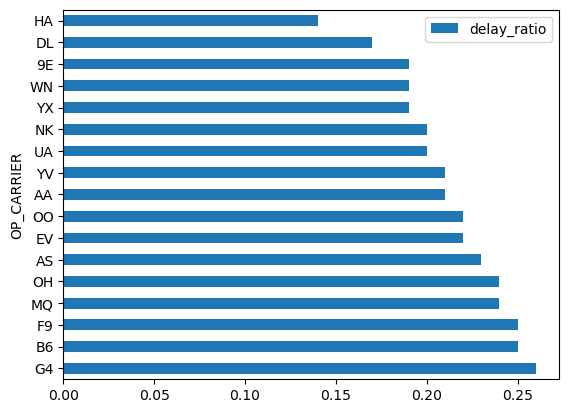

In [25]:
# 항공사별 지연율 
# 상위 5개 : 'G4':'Allegiant Air' / 'B6':'JetBlue Airways' / 'F9':'Frontier Airlines' / 'MQ':'Envoy Air' / 'OH':'PSA Airlines'
# DL -> 미국 항공사 중 가장 큰 대형항공사
# HA -> 운항횟수가 가장 적은 미국의 항공사

delay_ratio_df.toPandas().plot(kind = 'barh', x = 'OP_CARRIER', y = 'delay_ratio')

In [44]:
# 요일별 지연 횟수 (그래프로)

# 연착된 날 선택
delay_day_df = flight_df.where('DEP_DEL15 = 1 or ARR_DEL15 = 1')

# DAY_OF_WEEK -> 숫자로 되어있는 요일을 한글로 변환
d = {1:'SUN', 2:'MON', 3:'TUE', 4:'WED', 5:'THU', 6:'FRI', 7:'SAT'}
ff = f.udf(lambda v : d[v])

delay_day_df = delay_day_df.withColumn('day', ff(delay_day_df['DAY_OF_WEEK']))

# 연착된 날 요일별로 group
delay_day_df = delay_day_df.groupby('day').agg(f.count('OP_CARRIER').alias('delay_num')).orderBy(f.desc('delay_num'))
delay_day_df.show()

+---+---------+
|day|delay_num|
+---+---------+
|WED|    89945|
|THU|    78849|
|TUE|    69933|
|SUN|    65135|
|MON|    58690|
|SAT|    58556|
|FRI|    51903|
+---+---------+



<AxesSubplot:xlabel='day'>

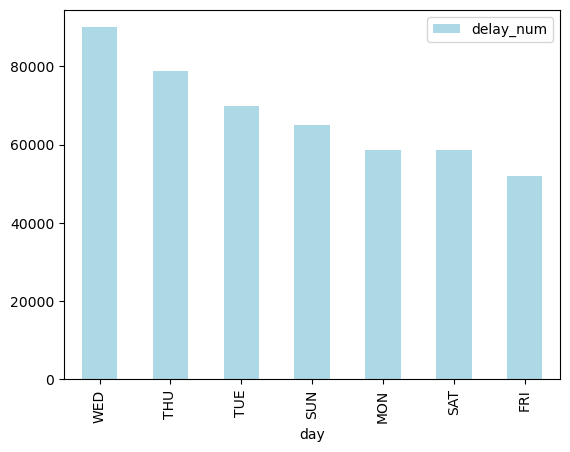

In [46]:
delay_day_df.toPandas().plot(kind = 'bar', x = 'day', y = 'delay_num', facecolor = 'lightblue')

In [61]:
# correlation
from pyspark.ml.stat import Correlation


#correlation을 위해 레이블인코딩
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols = ['OP_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST'], outputCols =['OP_CARRIER_label', 'TAIL_NUM_label', 'ORIGIN_label', 'DEST_label'])
label_df = indexer.fit(flight_df).transform(flight_df)
label_df.show()

+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+----------------+--------------+------------+----------+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_CARRIER|TAIL_NUM|OP_CARRIER_FL_NUM|ORIGIN_AIRPORT_SEQ_ID|ORIGIN|DEST_AIRPORT_SEQ_ID|DEST|DEP_DEL15|DEP_TIME_BLK|ARR_DEL15|CANCELLED|DIVERTED|DISTANCE|OP_CARRIER_label|TAIL_NUM_label|ORIGIN_label|DEST_label|
+------------+-----------+----------+--------+-----------------+---------------------+------+-------------------+----+---------+------------+---------+---------+--------+--------+----------------+--------------+------------+----------+
|           1|          6|        MQ|  N269NN|             3825|              1393007|   ORD|            1537002| TUL|      0.0|   1600-1659|      0.0|      0.0|     0.0|   585.0|             6.0|        3972.0|         1.0|      74.0|
|           1|          6|        MQ|  N908AE|          

In [62]:
label_df = label_df.drop('OP_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST', 'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 'DEP_TIME_BLK')
label_df.show()

+------------+-----------+-----------------+---------+---------+---------+--------+--------+----------------+--------------+------------+----------+
|DAY_OF_MONTH|DAY_OF_WEEK|OP_CARRIER_FL_NUM|DEP_DEL15|ARR_DEL15|CANCELLED|DIVERTED|DISTANCE|OP_CARRIER_label|TAIL_NUM_label|ORIGIN_label|DEST_label|
+------------+-----------+-----------------+---------+---------+---------+--------+--------+----------------+--------------+------------+----------+
|           1|          6|             3825|      0.0|      0.0|      0.0|     0.0|   585.0|             6.0|        3972.0|         1.0|      74.0|
|           1|          6|             3829|      0.0|      0.0|      0.0|     0.0|   765.0|             6.0|          80.0|        18.0|      26.0|
|           1|          6|             3831|      0.0|      1.0|      0.0|     0.0|   294.0|             6.0|          78.0|       143.0|      22.0|
|           1|          6|             3833|      0.0|      0.0|      0.0|     0.0|   229.0|             6

In [66]:
label_df.columns

['DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'OP_CARRIER_FL_NUM',
 'DEP_DEL15',
 'ARR_DEL15',
 'CANCELLED',
 'DIVERTED',
 'DISTANCE',
 'OP_CARRIER_label',
 'TAIL_NUM_label',
 'ORIGIN_label',
 'DEST_label']

In [70]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=label_df.columns, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(label_df).select(vector_col)

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

In [72]:
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder.getOrCreate()

In [73]:
corr_df = spark.createDataFrame(corrmatrix, label_df.columns)
corr_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        DAY_OF_MONTH|         DAY_OF_WEEK|   OP_CARRIER_FL_NUM|           DEP_DEL15|           ARR_DEL15|           CANCELLED|            DIVERTED|            DISTANCE|    OP_CARRIER_label|      TAIL_NUM_label|        ORIGIN_label|          DEST_label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-0.04547277596772...|-0.00913219193600...|-0.01006863342365...|-0.00903850828839...|0.024367348859866158|-0.00263027047999...|-0.00975318631319...|-0.00152190198136...|9.956802529506696E-4|4.227483365584530...|1.4836

/tmp/ipykernel_3946/1025579341.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
/tmp/ipykernel_3946/1025579341.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


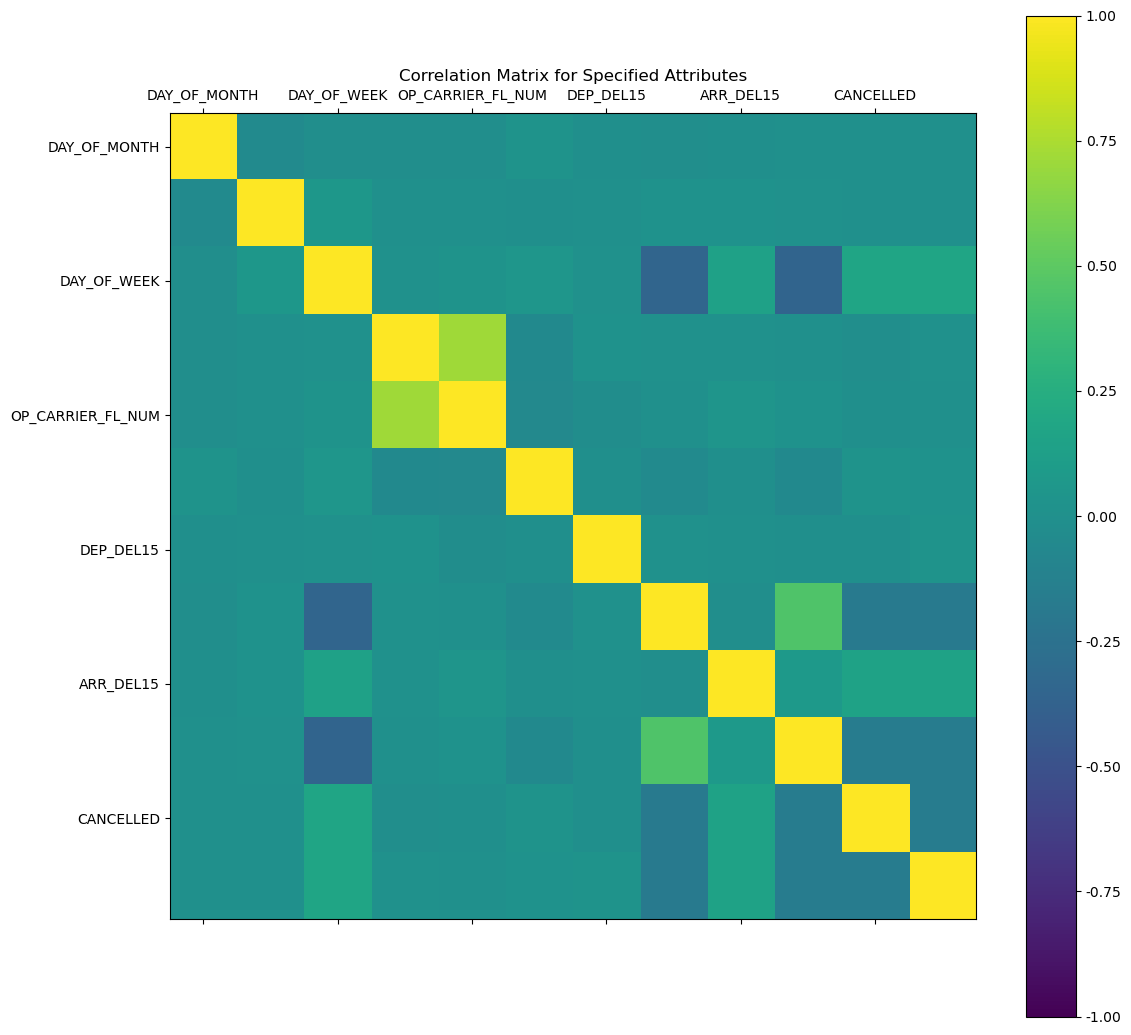

In [98]:
def plot_corr_matrix(correlations,attr):
    fig=plt.figure(figsize=(13, 13))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, label_df.columns)

### MODEL

In [85]:
from pyspark.ml.regression import LinearRegression

In [86]:
label_df.columns

['DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'OP_CARRIER_FL_NUM',
 'DEP_DEL15',
 'ARR_DEL15',
 'CANCELLED',
 'DIVERTED',
 'DISTANCE',
 'OP_CARRIER_label',
 'TAIL_NUM_label',
 'ORIGIN_label',
 'DEST_label']

In [89]:
r = VectorAssembler(inputCols=label_df.columns, outputCol="features")
r_df = r.transform(label_df)
r_df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[1.0,6.0,3825.0,0...|
|[1.0,6.0,3829.0,0...|
|[1.0,6.0,3831.0,0...|
|[1.0,6.0,3833.0,0...|
|[1.0,6.0,3833.0,0...|
|[1.0,6.0,3837.0,0...|
|[1.0,6.0,3838.0,0...|
|[1.0,6.0,3840.0,0...|
|[1.0,6.0,3841.0,0...|
|[1.0,6.0,3841.0,0...|
|[1.0,6.0,3842.0,0...|
|[1.0,6.0,3843.0,0...|
|[1.0,6.0,3844.0,0...|
|[1.0,6.0,3844.0,0...|
|[1.0,6.0,3845.0,0...|
|[1.0,6.0,3849.0,0...|
|[1.0,6.0,3851.0,0...|
|[1.0,6.0,3853.0,0...|
|[1.0,6.0,3854.0,0...|
|[1.0,6.0,3854.0,0...|
+--------------------+
only showing top 20 rows



In [90]:
train_df,test_df = r_df.randomSplit([0.8,0.2])

In [92]:
lr = LinearRegression(featuresCol="features", labelCol="DEP_DEL15", maxIter=50, regParam=0.01, predictionCol="predic_weight")
lr_model = lr.fit(train_df)
print("기울기(w)",lr_model.coefficients)
print("절편(b)", lr_model.intercept)
s = lr_model.summary
print("RMSE:", s.rootMeanSquaredError)

22/12/26 14:01:27 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


기울기(w) [-6.482350510276646e-06,4.6027857269100066e-05,-1.3635859424031265e-08,0.9482559776572678,0.03556582208560761,-0.0015501575245265907,0.013498384439818992,3.258464683657707e-07,-5.614157147308852e-05,-1.9020827532150308e-07,-3.211208467420381e-06,1.0622480172462246e-06]
절편(b) 0.0027967070911377742
RMSE: 0.01328384721109353


In [93]:
tdf = lr_model.transform(test_df)
tdf.toPandas()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,DEP_DEL15,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,OP_CARRIER_label,TAIL_NUM_label,ORIGIN_label,DEST_label,features,predic_weight
0,1,6,1,0.0,0.0,0.0,0.0,2329.0,10.0,4369.0,15.0,17.0,"[1.0, 6.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2329.0, 10...",0.002403
1,1,6,2,0.0,0.0,0.0,0.0,2329.0,10.0,4369.0,17.0,15.0,"[1.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2329.0, 10...",0.002394
2,1,6,2,0.0,0.0,0.0,0.0,2556.0,16.0,5158.0,38.0,5.0,"[1.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2556.0, 16...",0.001903
3,1,6,3,1.0,0.0,0.0,0.0,1182.0,12.0,1988.0,1.0,20.0,"[1.0, 6.0, 3.0, 1.0, 0.0, 0.0, 0.0, 1182.0, 12...",0.950674
4,1,6,4,0.0,0.0,0.0,0.0,577.0,12.0,1549.0,23.0,0.0,"[1.0, 6.0, 4.0, 0.0, 0.0, 0.0, 0.0, 577.0, 12....",0.002212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458664,31,4,7428,0.0,0.0,0.0,0.0,150.0,3.0,931.0,245.0,19.0,"[31.0, 4.0, 7428.0, 0.0, 0.0, 0.0, 0.0, 150.0,...",0.001615
458665,31,4,7431,0.0,0.0,0.0,0.0,150.0,3.0,198.0,19.0,244.0,"[31.0, 4.0, 7431.0, 0.0, 0.0, 0.0, 0.0, 150.0,...",0.002720
458666,31,4,7437,0.0,0.0,0.0,0.0,257.0,3.0,1534.0,13.0,312.0,"[31.0, 4.0, 7437.0, 0.0, 0.0, 0.0, 0.0, 257.0,...",0.002592
458667,31,4,7438,0.0,0.0,0.0,0.0,200.0,3.0,931.0,19.0,311.0,"[31.0, 4.0, 7438.0, 0.0, 0.0, 0.0, 0.0, 200.0,...",0.002667


In [99]:
lrAll = LinearRegression( featuresCol="DEP_DEL15", labelCol="weight",maxIter=50,regParam=0.01, predictionCol="predic_weight")

In [101]:
lr_modelAll = lr.fit(r_df)

In [104]:
tdfAll = lr_model.transform(r_df)
pd = tdfAll.toPandas()

Py4JJavaError: An error occurred while calling o1333.collectToPython.
: java.lang.OutOfMemoryError: GC overhead limit exceeded


In [ ]:
plt.plot(pd['weight'])
plt.plot(pd['predic_weight'],'r--')
plt.show()